In [3]:
import torch
import torch.nn
import torchvision

from torch import nn
from torchvision import transforms

import matplotlib.pyplot as plt
import os
import random
print(f"torch version : {torch.__version__}")

torch version : 2.5.1+cu121


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [7]:
image_path = "/content/drive/MyDrive/oversampling_data"

In [8]:
# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from pytorch_modules.pytorch_modules import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/DutchVandaline/Artificial_Intelligence.git
    !mv Artificial_Intelligence/pytorch_modules .
    !mv Artificial_Intelligence/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from pytorch_modules.pytorch_modules import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'Artificial_Intelligence'...
remote: Enumerating objects: 363, done.
remote: Counting objects: 100% (299/299), done.
remote: Compressing objects: 100% (219/219), done.
remote: Total 363 (delta 131), reused 200 (delta 70), pack-reused 64 (from 1)
Receiving objects: 100% (363/363), 41.70 MiB | 15.69 MiB/s, done.
Resolving deltas: 100% (147/147), done.


In [9]:
# Count Image Data length
import os
def walk_through_dir(dir_path):
  """ Walks through dir_path returning its conents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directoreis and {len(filenames)} images in '{dirpath}'.")
walk_through_dir(image_path)

There are 3 directoreis and 0 images in '/content/drive/MyDrive/oversampling_data'.
There are 2 directoreis and 0 images in '/content/drive/MyDrive/oversampling_data/test'.
There are 0 directoreis and 353 images in '/content/drive/MyDrive/oversampling_data/test/normal'.
There are 0 directoreis and 393 images in '/content/drive/MyDrive/oversampling_data/test/defect'.
There are 2 directoreis and 0 images in '/content/drive/MyDrive/oversampling_data/z_keep_out_for_final_test'.
There are 0 directoreis and 20 images in '/content/drive/MyDrive/oversampling_data/z_keep_out_for_final_test/defect'.
There are 0 directoreis and 20 images in '/content/drive/MyDrive/oversampling_data/z_keep_out_for_final_test/normal'.
There are 2 directoreis and 0 images in '/content/drive/MyDrive/oversampling_data/train'.
There are 0 directoreis and 1409 images in '/content/drive/MyDrive/oversampling_data/train/normal'.
There are 0 directoreis and 1569 images in '/content/drive/MyDrive/oversampling_data/train/defe

In [12]:
oversampling_train_dir = "/content/drive/MyDrive/oversampling_data/train"
oversampling_test_dir = "/content/drive/MyDrive/oversampling_data/test"

In [13]:
# Get the transforms used to create our pretrained weights
manual_transforms = transforms.Compose([
    transforms.Resize((2532, 824)), # normal은 2532임 defect는 2732
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
manual_transforms

Compose(
    Resize(size=(2532, 824), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [15]:
#Set up dataloaders
from pytorch_modules.pytorch_modules import data_setup
oversampling_train_dataloader, oversampling_test_dataloader, class_names = data_setup.create_dataloaders(train_dir=oversampling_train_dir,
                                                                                                     test_dir=oversampling_test_dir,
                                                                                                     transform=manual_transforms,
                                                                                                    num_workers=0,
                                                                                                     batch_size=16)
len(class_names)

2

In [16]:
from torch import nn

class TinyVGG(nn.Module):
  """
  Model architecture copying TinyVGG from CNN explainer
  """
  def __init__(self,
                input_shape:int,
                hidden_units:int,
                output_shape = int) -> None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size = 3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                      stride = 2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size = 3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                      stride = 2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units * 127890,
                  out_features = output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    #print(x.shape)
    x=self.conv_block_2(x)
    #print(x.shape)
    x = self.classifier(x)
    #print(x.shape)
    return x
      #return self.classifier(self.conv_block2(self.conv_block_1(x))) # benefits from opterator fusion

In [17]:
tinyVGG = TinyVGG(input_shape=3, hidden_units=10, output_shape=len(class_names)).to(device)
tinyVGG

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1278900, out_features=2, bias=True)
  )
)

In [18]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(tinyVGG.parameters(), lr= 0.001)

In [19]:
torch.cuda.empty_cache()
device

'cuda'

In [ ]:
from pytorch_modules.pytorch_modules import engine

from timeit import default_timer as timer
start_time = timer()

results = engine.train(model=tinyVGG,
                       train_dataloader=oversampling_train_dataloader,
                       test_dataloader =oversampling_test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time: .3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
from pytorch_modules.pytorch_modules.predictions import pred_and_plot_image
input_image = "C:/junha/Personal_Notebook/oversampling_data/z_keep_out_for_final_test/normal/20240823_101759.jpg"

pred_and_plot_image(model=tinyVGG,
                           image_path=input_image,
                           class_names=class_names,
                            transform=manual_transforms)

In [ ]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Ensure the model is in evaluation mode
tinyVGG.eval()

# Create lists to store true and predicted labels
true_labels = []
predicted_labels = []

# Move model to the appropriate device (e.g., CPU or GPU)
tinyVGG.to(device)

# Disable gradient calculation for evaluation
with torch.no_grad():
    for data in oversampling_test_dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = tinyVGG(inputs)
        _, preds = torch.max(outputs, 1)

        # Collect predictions and true labels
        predicted_labels.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


In [ ]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, roc_curve, auc
import numpy as np

# Ensure the model is in evaluation mode and move it to the appropriate device
tinyVGG.to(device)
tinyVGG.eval()

# Create lists to store true and predicted labels
true_labels = []
predicted_labels = []
all_probabilities = []

# Disable gradient calculation for evaluation
with torch.no_grad():
    for data in oversampling_test_dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = tinyVGG(inputs)
        _, preds = torch.max(outputs, 1)

        # Collect predictions, true labels, and predicted probabilities
        predicted_labels.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
        all_probabilities.extend(torch.softmax(outputs, dim=1).cpu().numpy())

# Calculate F1 score (micro and macro)
f1_micro = f1_score(true_labels, predicted_labels, average='micro')
f1_macro = f1_score(true_labels, predicted_labels, average='macro')
print(f"F1 Score (Micro): {f1_micro}")
print(f"F1 Score (Macro): {f1_macro}")

# Check if the task is binary classification
if len(np.unique(true_labels)) == 2:
    # Binary classification: Use only one ROC curve
    probabilities_class_1 = np.array(all_probabilities)[:, 1]
    fpr, tpr, thresholds = roc_curve(true_labels, probabilities_class_1)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve for binary classification
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')

# Print total count of true and predicted labels for debugging
print(f"Total true labels collected: {len(true_labels)}")
print(f"Total predicted labels collected: {len(predicted_labels)}")
print(f"True Labels: {true_labels}")
print(f"Predicted Labels: {predicted_labels}")


# Plot settings
plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


In [ ]:
from pytorch_modules.pytorch_modules import utils

utils.save_model(model=tinyVGG,
                 target_dir="/content/drive/MyDrive/models",
                 model_name="tinyVGG_OverSampling.pth")

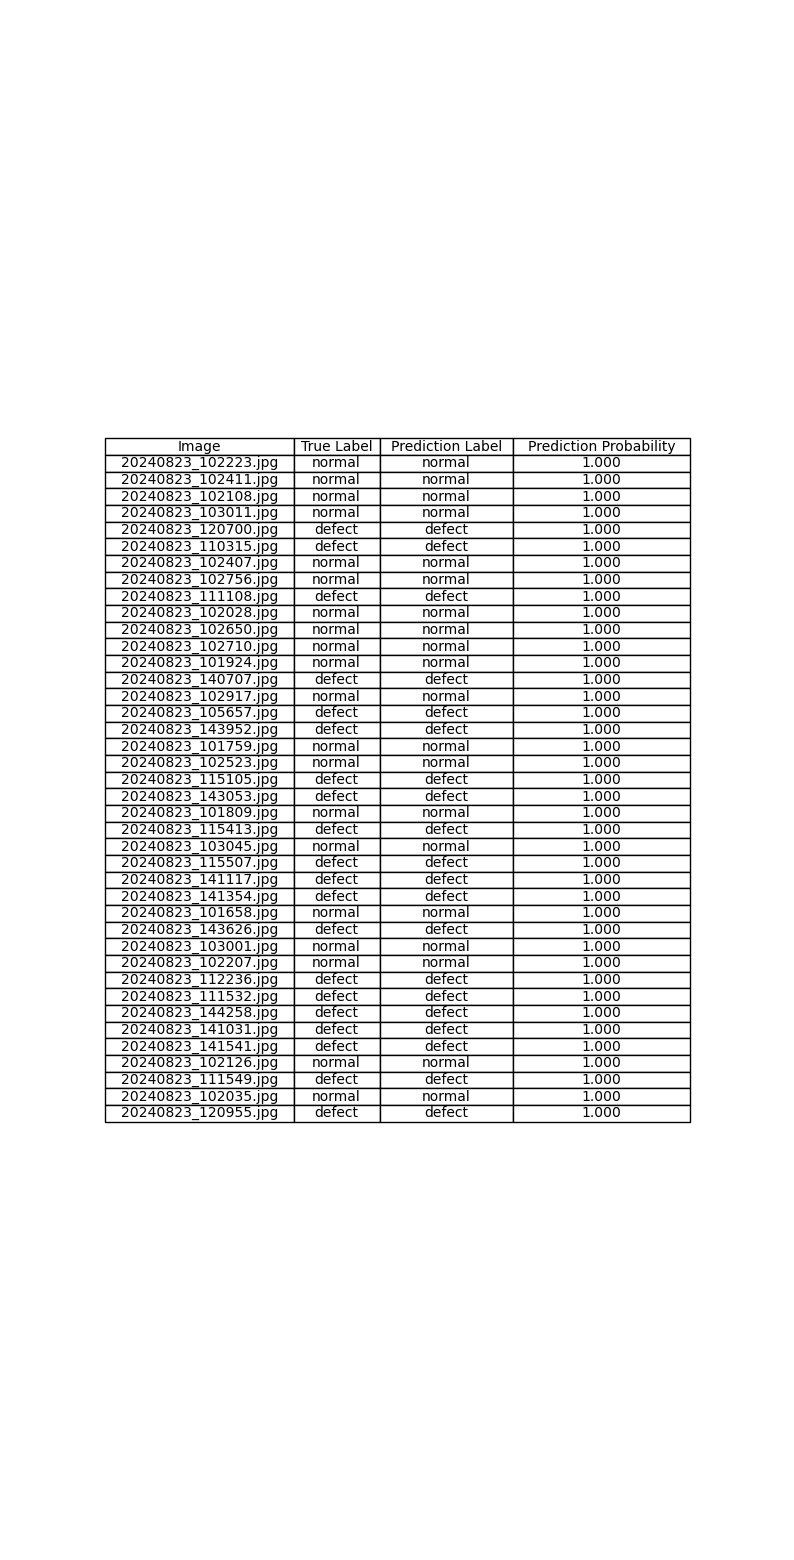

In [ ]:
import os
import random
import matplotlib.pyplot as plt
import pandas as pd
from pytorch_modules.pytorch_modules.predictions import pred_and_plot_image

# Define paths to normal and defect images
normal_folder = "/content/drive/MyDrive/oversampling_data/z_keep_out_for_final_test/normal"
defect_folder = "/content/drive/MyDrive/oversampling_data/z_keep_out_for_final_test/defect"

# List all images in normal and defect folders with labels
normal_images = [(os.path.join(normal_folder, img), "normal") for img in os.listdir(normal_folder)]
defect_images = [(os.path.join(defect_folder, img), "defect") for img in os.listdir(defect_folder)]

# Combine and shuffle the images
all_images = normal_images + defect_images
random.shuffle(all_images)

# Initialize list to store predictions
results = []

# Iterate over each image, predict, and store the results
for image_path, true_label in all_images:
    # Predict the label using the model
    pred_and_plot_image(model=tinyVGG, image_path=image_path, class_names=class_names, transform=manual_transforms)

    # Extract the prediction label and probability from the plot title
    plt_title = plt.gca().get_title()  # Get title containing label and probability
    pred_label = plt_title.split('|')[0].split(': ')[1].strip()
    pred_prob = plt_title.split('|')[1].split(': ')[1].strip()  # No conversion, keep the original

    # Append results including true label
    results.append([os.path.basename(image_path), true_label, pred_label, pred_prob])

    # Close the plot to manage resources
    plt.close()

# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=["Image", "True Label", "Prediction Label", "Prediction Probability"])

# Display results in a table
fig, ax = plt.subplots(figsize=(10, len(results)*0.5))  # Adjust height based on number of rows
ax.axis('off')  # Turn off the axis
table = ax.table(cellText=results_df.values, colLabels=results_df.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(results_df.columns))))

plt.show()